In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os

In [8]:
performance_data_new = pd.read_csv("../results/classic_full_inference2/trial_results/training_log_293.csv").set_index("epoch").drop("index", axis = 1)


performance_data_old = pd.read_csv("../results/classic_training_log.csv").set_index("epoch").drop("index", axis = 1)

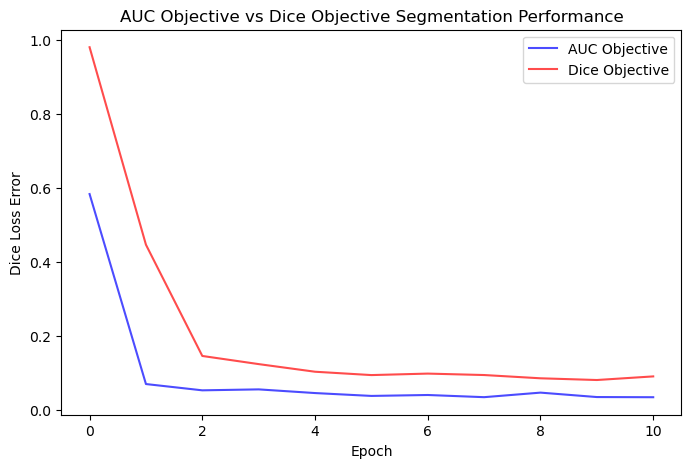

In [17]:
fig = plt.figure()
ax = plt.subplot(111)

figsize = (8,5)


performance_data_new['train_loss'].plot(ax = ax, figsize = figsize, color = 'b', alpha = 0.7, label='AUC Objective')
performance_data_old['train_loss'].loc[0:10].plot(ax = ax, figsize = figsize, color = 'r', alpha = 0.7, label='Dice Objective')

ax.set_title("AUC Objective vs Dice Objective Segmentation Performance")
ax.set_xlabel("Epoch")
ax.set_ylabel("Dice Loss Error")

leg = plt.legend(loc='upper right')

plt.savefig("auc_vs_dice.png", dpi = 200)

In [10]:
echo_data = pd.read_csv("../results/echo3/holodecml.csv").set_index("number")

In [13]:
echo_data.head()

,value,datetime_start,datetime_complete,duration,params_encoder_name,params_learning_rate,params_lookahead,params_mode,params_model_name,params_train_batch_size,params_training_loss,params_weight_decay,state
number,,,,,,,,,,,,,
0,0.998928,2023-07-18 13:18:26.053657,2023-07-18 18:05:31.398798,0 days 04:47:05.345141,efficientnet-b0,0.003592,3.0,255,pan,3.0,lovasz-hinge,6.633993e-05,COMPLETE
1,NaN,2023-07-18 13:18:26.139369,2023-07-18 13:18:28.526480,0 days 00:00:02.387111,vgg11,0.000062,2.0,norm,deeplabv3,13.0,focal,4.236227e-10,PRUNED
2,0.174610,2023-07-18 13:18:27.388768,2023-07-19 04:07:36.013614,0 days 14:49:08.624846,dpn68,0.000276,2.0,sym,unet++,10.0,tyversky,3.887803e-08,COMPLETE
3,NaN,2023-07-18 13:18:28.202328,2023-07-18 13:18:32.015200,0 days 00:00:03.812872,vgg11,0.000248,0.0,stan,pan,4.0,dice,2.169664e-09,PRUNED
4,0.999443,2023-07-18 13:18:28.202822,2023-07-18 22:34:23.298288,0 days 09:15:55.095466,dpn68,0.000070,2.0,norm,manet,14.0,lovasz-hinge,5.111737e-05,COMPLETE


In [14]:
echo_data.shape
echo_data.dropna(axis = 0)

,value,datetime_start,datetime_complete,duration,params_encoder_name,params_learning_rate,params_lookahead,params_mode,params_model_name,params_train_batch_size,params_training_loss,params_weight_decay,state
number,,,,,,,,,,,,,
0,0.998928,2023-07-18 13:18:26.053657,2023-07-18 18:05:31.398798,0 days 04:47:05.345141,efficientnet-b0,0.003592,3.0,255,pan,3.0,lovasz-hinge,6.633993e-05,COMPLETE
2,0.174610,2023-07-18 13:18:27.388768,2023-07-19 04:07:36.013614,0 days 14:49:08.624846,dpn68,0.000276,2.0,sym,unet++,10.0,tyversky,3.887803e-08,COMPLETE
4,0.999443,2023-07-18 13:18:28.202822,2023-07-18 22:34:23.298288,0 days 09:15:55.095466,dpn68,0.000070,2.0,norm,manet,14.0,lovasz-hinge,5.111737e-05,COMPLETE
5,0.998789,2023-07-18 13:18:28.202806,2023-07-19 01:48:20.713776,0 days 12:29:52.510970,xception,0.002371,3.0,norm,manet,9.0,tyversky,6.579885e-10,COMPLETE
6,0.999434,2023-07-18 13:18:29.137924,2023-07-19 00:57:21.851213,0 days 11:38:52.713289,resnet18,0.000769,1.0,norm,unet++,8.0,lovasz-hinge,8.776792e-08,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0.147629,2023-07-24 09:12:45.532169,2023-07-25 01:00:39.539898,0 days 15:47:54.007729,mobilenet_v2,0.000711,0.0,stan,deeplabv3+,21.0,tyversky,2.662016e-07,COMPLETE
349,0.131068,2023-07-24 09:12:47.005650,2023-07-25 02:52:23.559865,0 days 17:39:36.554215,mobilenet_v2,0.000715,0.0,stan,deeplabv3+,21.0,tyversky,2.666670e-07,COMPLETE
350,0.163908,2023-07-24 09:12:47.640080,2023-07-24 19:52:25.290467,0 days 10:39:37.650387,mobilenet_v2,0.000716,0.0,stan,deeplabv3+,21.0,tyversky,2.894228e-07,COMPLETE


In [15]:
completion_rate = echo_data[["state"]].value_counts(normalize = True)

In [16]:
completion_rate.head()

state   
FAIL        0.456091
COMPLETE    0.424929
PRUNED      0.079320
RUNNING     0.039660
dtype: float64

[Text(0.5, 0, 'Validation Loss'),
 Text(0, 0.5, 'Models'),
 Text(0.5, 1.0, 'Distribution of Loss Values over ECHO-OPT')]

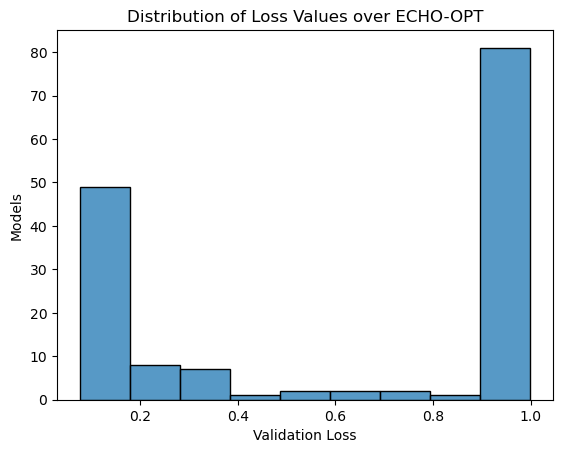

In [17]:
sns.histplot(data = echo_data, x = "value").set(xlabel = "Validation Loss", ylabel = "Models", title = "Distribution of Loss Values over ECHO-OPT")

In [ ]:
hist_data = "../results/echo3/trial_results"

total_performance_data = pd.DataFrame()

configurations = []



for filename in os.scandir(hist_data):
    if filename.is_file():
        df = pd.read_csv(str(filename.path))
        configurations.append(df)


fig = plt.figure()
ax = plt.subplot(111)

figsize = (8,5)

for df in configurations:
    if 'valid_loss' in df:
        df['valid_loss'].plot(ax = ax, figsize = figsize, color = 'k', alpha = 0.2, label='_nolegend_')
        
pd.read_csv("../results/echo3/trial_results/training_log_155.csv")['valid_loss'].plot(ax = ax, figsize = figsize, color = 'r', alpha = 1.0, label = "Optimal Model")
leg = plt.legend(loc='upper right')        

        
ax.set_title("Validation Loss across Model Configurations")
ax.set_xlabel("Epochs")
ax.set_ylabel("Dice Coefficient Loss")

plt.savefig("echo3_validation_performance.png", dpi = 200)